# High-Dimensional Time Series Forecasting with Convolutional Neural Networks

**Note**: for a written overview on this topic, check out my [blog post](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/). 

This notebook aims to demonstrate in python/keras code how a **convolutional** sequence-to-sequence neural network can be built for the purpose of high-dimensional time series forecasting. For an introduction to neural network forecasting with an LSTM architecture, check out the [first notebook in this series](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb). I assume working familiarity with 1-dimensional convolutions, and recommend checking out [Chris Olah's blog post](http://colah.github.io/posts/2014-07-Understanding-Convolutions/) if you want a nice primer.  

In this notebook I'll be using the daily wikipedia web page traffic dataset again, available [here on Kaggle](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data). The corresponding competition called for forecasting 60 days into the future, but for this demonstration we'll simplify to forecasting only 14 days. However, we will use all of the series history available in "train_1.csv" for the encoding stage of the model. 

Our goal here is to show a relatively simple implementation of the core convolutional seq2seq architecture that can be nicely applied to this problem. In particular, I'll use a stack of **1-dimensional causal convolutions with exponentially increasing dilation rates**, as in the [WaveNet model](https://arxiv.org/pdf/1609.03499.pdf). Don't worry, I'll explain what all that means in section 3! Feel free to skip ahead to that section if you're comfortable with the data setup and formatting (it's the same as in the previous notebook), and want to get right into the neural network.     

Here's a section breakdown of this notebook -- enjoy!

**1. Loading and Previewing the Data**   
**2. Formatting the Data for Modeling**  
**3. Building the Model - Training Architecture**  
**4. Building the Model - Inference Loop**  
**5. Generating and Plotting Predictions**

## 1. Loading and Previewing the Data 

First thing's first, let's load up the data and get a quick feel for it (reminder that the dataset is available [here](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data)). 

Note that there are a good number of NaN values in the data that don't disambiguate missing from zero. For the sake of simplicity in this tutorial, we'll naively fill these with 0 later on.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from google.colab import drive
drive.mount("/content/gdrive")

df = pd.read_csv('/content/gdrive/MyDrive/train_1.csv')
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [ ]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2016-12-31


We can define a function that lets us visualize some random webpage series as below. For the sake of smoothing out the scale of traffic across different series, we apply a log1p transformation before plotting - i.e. take $\log(1+x)$ for each value $x$ in a series.

/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12465 (\N{KATAKANA LETTER KE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 31478 (\N{CJK UNIFIED IDEOGRAPH-7AF6}) missing from current font.
  func(*args, *

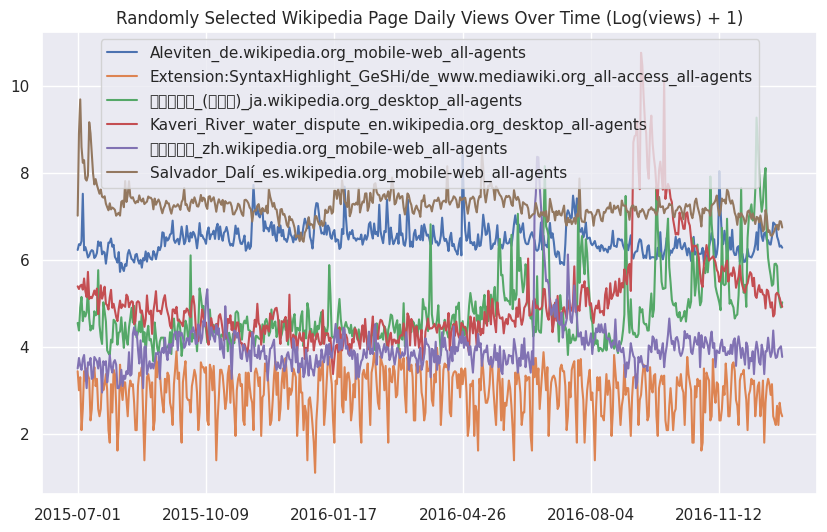

In [ ]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    page_labels = sample['Page'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
plot_random_series(df, 6)

## 2. Formatting the Data for Modeling 

Sadly we can't just throw the dataframe we've created into keras and let it work its magic. Instead, we have to set up a few data transformation steps to extract nice numpy arrays that we can pass to keras. But even before doing that, we have to know how to appropriately partition the time series into encoding and prediction intervals for the purposes of training and validation. Note that for our simple convolutional model we won't use an encoder-decoder architecture like in the first notebook, but **we'll keep the "encoding" and "decoding" (prediction) terminology to be consistent** -- in this case, the encoding interval represents the entire series history that we will use for the network's feature learning, but not output any predictions on. 

We'll use a style of **walk-forward validation**, where our validation set spans the same time-range as our training set, but shifted forward in time (in this case by 14 days). This way, we simulate how our model will perform on unseen data that comes in the future. 

[Artur Suilin](https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md) has created a very nice image that visualizes this validation style and contrasts it with traditional validation. I highly recommend checking out his entire repo, as he's implemented a truly state of the art (and competition winning) seq2seq model on this data set. 

![architecture](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/images/ArturSuilin_validation.png?raw=1)

### Train and Validation Series Partioning

We need to create 4 sub-segments of the data:

    1. Train encoding period
    2. Train decoding period (train targets, 14 days)
    3. Validation encoding period
    4. Validation decoding period (validation targets, 14 days)
    
We'll do this by finding the appropriate start and end dates for each segment. Starting from the end of the data we've loaded, we'll work backwards to get validation and training prediction intervals. Then we'll work forward from the start to get training and validation encoding intervals. 

In [ ]:
from datetime import timedelta

pred_steps = 14
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1) 

In [1]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1) 

NameError: ignored

In [ ]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-07-01 00:00:00 - 2016-12-03 00:00:00
Train prediction: 2016-12-04 00:00:00 - 2016-12-17 00:00:00 

Val encoding: 2015-07-15 00:00:00 - 2016-12-17 00:00:00
Val prediction: 2016-12-18 00:00:00 - 2016-12-31 00:00:00

Encoding interval: 522
Prediction interval: 14


### Keras Data Formatting

Now that we have the time segment dates, we'll define the functions we need to extract the data in keras friendly format. Here are the steps:

* Pull the time series into an array, save a date_to_index mapping as a utility for referencing into the array 
* Create function to extract specified time interval from all the series 
* Create functions to transform all the series. 
    - Here we smooth out the scale by taking log1p and de-meaning each series using the encoder series mean, then reshape to the **(n_series, n_timesteps, n_features) tensor format** that keras will expect. 
    - Note that if we want to generate true predictions instead of log scale ones, we can easily apply a reverse transformation at prediction time. 

In [ ]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

## 3. Building the Model - Architecture

This convolutional architecture is a simplified version of the [WaveNet model](https://deepmind.com/blog/wavenet-generative-model-raw-audio/), designed as a generative model for audio (in particular, for text-to-speech applications). The wavenet model can be abstracted beyond audio to apply to any time series forecasting problem, providing a nice structure for capturing long-term dependencies without an excessive number of learned weights.

The core building block of the wavenet model is the **dilated causal convolution layer**. It utilizes some other key techniques like *gated activations* and *skip connections*, but for now we'll focus on the central idea of the architecture to keep things simple (check out the next notebook in the series for these). I'll explain this style of convolution (causal and dilated), then show how to implement our simplified WaveNet architecture in keras. 


### **Causal Convolutions**

In a traditional 1-dimensional convolution layer, as in the image below taken from [Chris Olah's excellent blog](http://colah.github.io/posts/2014-07-Understanding-Convolutions/), we slide a filter of weights across an input series, sequentially applying it to (usually overlapping) regions of the series. The output shape will depend on the sequence padding used, and is closely related to the connection structure between inputs and outputs. In this example, a filter of width 2, stride of 1, and no padding means that the output sequence will have one fewer entry than the input.      

![1dconv](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/images/Colah_1DConv.png?raw=1)

In the image, imagine that $y_0,..., y_7$ are each prediction outputs for the time steps that follow the series values $x_0,...,x_7$. There is a clear problem - since $x_1$ influences the output $y_0$, **we would be using the future to predict the past, which is cheating!** Letting the future of a sequence influence our interpretation of its past makes sense in a context like text classification where we use a known sequence to predict an outcome, but not in our time series context where we must generate future values in a sequence. 

To solve this problem, we adjust our convolution design to explicitly prohibit the future from influencing the past. In other words, we only allow inputs to connect to future time step outputs in a **causal** structure, as pictured below in a visualization from the WaveNet paper. In practice, this causal 1D structure is easy to implement by shifting traditional convolutional outputs by a number of timesteps. Keras handles it via setting ```padding = 'causal'```.     

![causalconv](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/images/WaveNet_causalconv.png?raw=1)

### **Dilated (Causal) Convolutions**

With causal convolutions we have the proper tool for handling temporal flow, but we need an additional modification to properly handle long-term dependencies. In the simple causal convolution figure above, you can see that only the 5 most recent timesteps can influence the highlighted output. In fact, **we would require one additional layer per timestep** to reach farther back in the series (to use proper terminology, to increase the output's **receptive field**). With a time series that extends for over a year, using simple causal convolutions to learn from the entire history would quickly make our model way too computationally and statistically complex. 

Instead of making that mistake, WaveNet uses **dilated convolutions**, which allow the receptive field to increase exponentially as a function of the number of convolutional layers. In a dilated convolution layer, filters are not applied to inputs in a simple sequential manner, but instead skip a constant **dilation rate** inputs in between each of the inputs they process, as in the WaveNet diagram below. By increasing the dilation rate multiplicatively at each layer (e.g. 1, 2, 4, 8, ...), we can achieve the exponential relationship between layer count and receptive field size that we desire. In the diagram, you can see how we now only need 4 layers to connect all of the 16 input series values to the highlighted output (say the 17th time step value).  

![dilatedconv](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/images/WaveNet_dilatedconv.png?raw=1)


### **Our Architecture**

Here's what we'll use:

* 8 dilated causal convolutional layers
    * 32 filters of width 2 per layer
    * Exponentially increasing dilation rate (1, 2, 4, 8, ..., 128) 
* 2 (time distributed) fully connected layers to map to final output 

We'll extract the last 14 steps from the output sequence as our predicted output for training. We'll use teacher forcing again during training. Similarly to the previous notebook, we'll have a separate function that runs an inference loop to generate predictions on unseen data, iteratively filling previous predictions into the history sequence (section 4).

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':14})(x)

model = Model(history_seq, pred_seq_train)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          96        
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          2080  

With our training architecture defined, we're ready to train the model! This will take some time if you're not running fancy hardware (read GPU). We'll leverage the transformer utility functions we defined earlier, and train using mean absolute error loss.

Note that for this simple model, we have fewer total parameters to train than we did with the simple LSTM architecture, and the model appears to converge with significantly fewer epochs (though we are using twice as much training data). But most interesting is that our predictions end up being clearly more expressive than before, indicating that this architecture is more naturally suited for learning the series' patterns (see section 5).

For better results, you could try using more data, adjusting the hyperparameters, tuning the learning rate and number of epochs, etc.  

In [ ]:
first_n_samples = 40000
batch_size = 2**11
epochs = 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

Epoch 1/10
16/16 [==============================] - 244s 15s/step - loss: 0.4907 - val_loss: 0.3750
Epoch 2/10
16/16 [==============================] - 240s 15s/step - loss: 0.3375 - val_loss: 0.3227
Epoch 3/10
16/16 [==============================] - 245s 15s/step - loss: 0.2985 - val_loss: 0.2930
Epoch 4/10
16/16 [==============================] - 248s 16s/step - loss: 0.2840 - val_loss: 0.2866
Epoch 5/10
16/16 [==============================] - 253s 16s/step - loss: 0.2798 - val_loss: 0.2873
Epoch 6/10
16/16 [==============================] - 239s 15s/step - loss: 0.2781 - val_loss: 0.2851
Epoch 7/10
16/16 [==============================] - 243s 15s/step - loss: 0.2763 - val_loss: 0.2850
Epoch 8/10
16/16 [==============================] - 242s 15s/step - loss: 0.2746 - val_loss: 0.2895
Epoch 9/10
16/16 [==============================] - 243s 15s/step - loss: 0.2740 - val_loss: 0.2827
Epoch 10/10
16/16 [==============================] - 243s 15s/step - loss: 0.2732 - val_loss: 0.2826

It's typically a good idea to look at the convergence curve of train/validation loss.

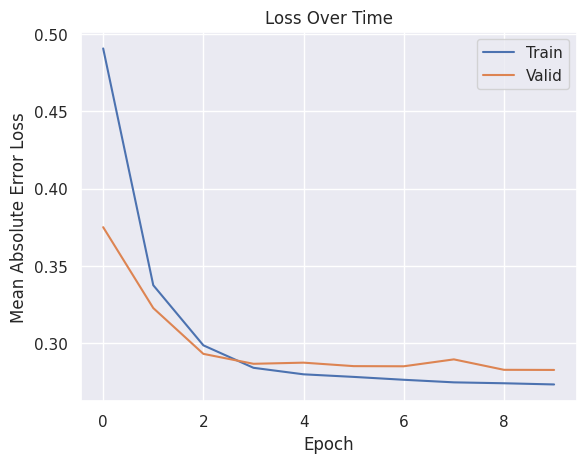

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

## 4. Building the Model - Inference Loop

Unlike in the previous notebook, we don't need to define a distinct keras model in order to actually generate predictions. Instead, we'll run our model from section 3 in a loop, using each iteration to extract the prediction for the time step one beyond our current history then append it to our history sequence. With 14 iterations, this lets us generate predictions for the full interval we've chosen. 

Recall that we designed our model to output predictions for 14 time steps at once in order to use teacher forcing for training. So if we start from a history sequence and want to predict the first future time step, we can run the model on the history sequence and take the last time step of the output, which corresponds to one time step beyond the history sequence.           

In [ ]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

## 5. Generating and Plotting Predictions 

Now we have everything we need to generate predictions for encoder (history) /target series pairs that we didn't train on (note again we're using "encoder"/"decoder" terminology to stay consistent with notebook 1 -- here it's more like history/target). We'll pull out our set of validation encoder/target series (recall that these are shifted forward in time). Then using a plotting utility function, we can look at the tail end of the encoder series, the true target series, and the predicted target series. This gives us a feel for how our predictions are doing.  

In [ ]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [ ]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

Generating some plots as below, we can see that our predictions look better than in the previous notebook. They can effectively anticipate many patterns in the data (e.g. behavior across different week days) and capture some trends nicely. They are definitely more sensitive to the variability in the data than the overly conservative LSTM predictions from the previous notebook. 

Still, we would likely stand to gain even more from increasing the sample size for training and expanding on the network architecture/hyperparameter tuning.  

**Check out the next notebook in this series** for further exploration of the WaveNet architecture, including fancier components like gated activations and skip connections. If you're interested in digging even deeper into state of the art WaveNet style architectures, I also highly recommend checking out [Sean Vasquez's model](https://github.com/sjvasquez/web-traffic-forecasting) that was designed for this data set. He implements a customized seq2seq WaveNet architecture in tensorflow.    

1/1 [==============================] - 0s 23ms/step


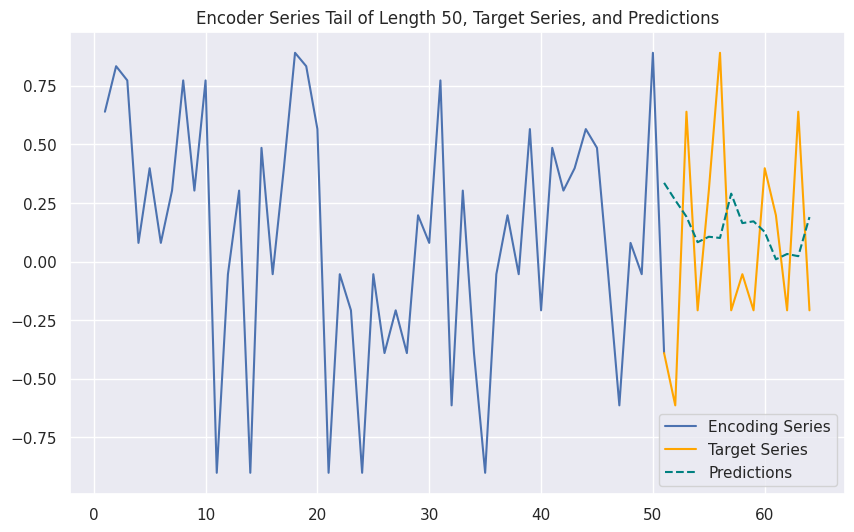

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 100)

1/1 [==============================] - 0s 34ms/step


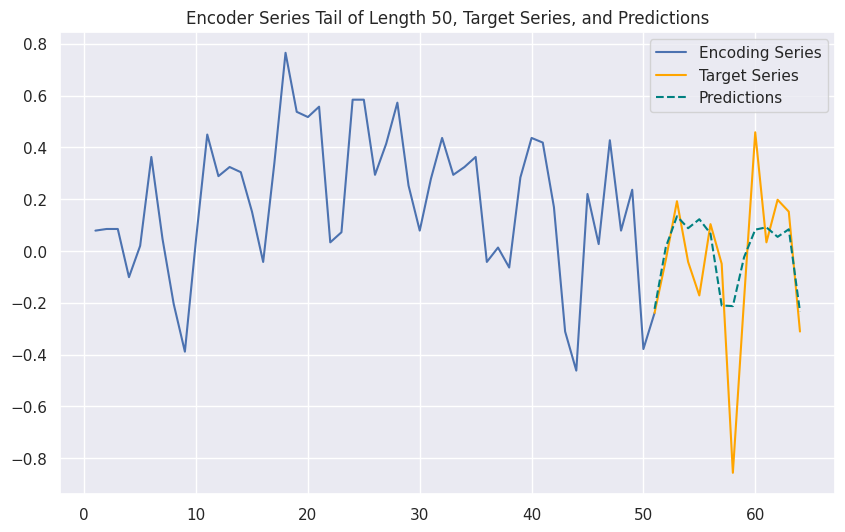

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 6007)

1/1 [==============================] - 0s 22ms/step


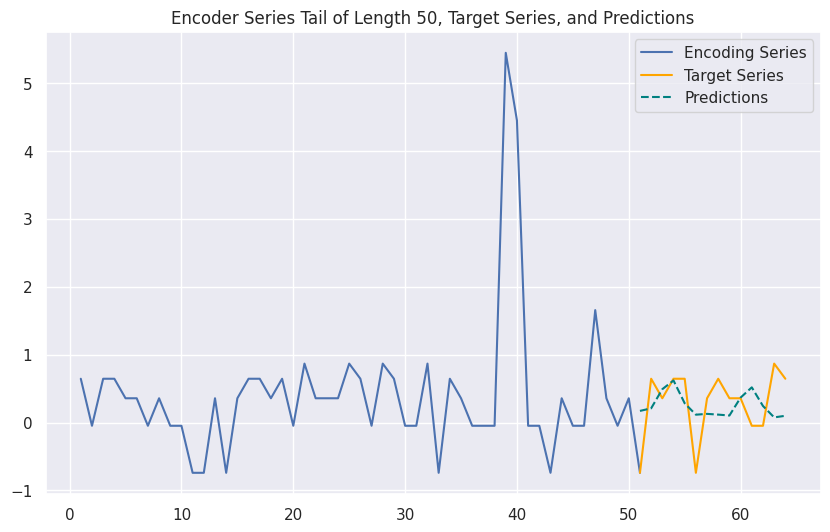

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 33000)

1/1 [==============================] - 0s 21ms/step


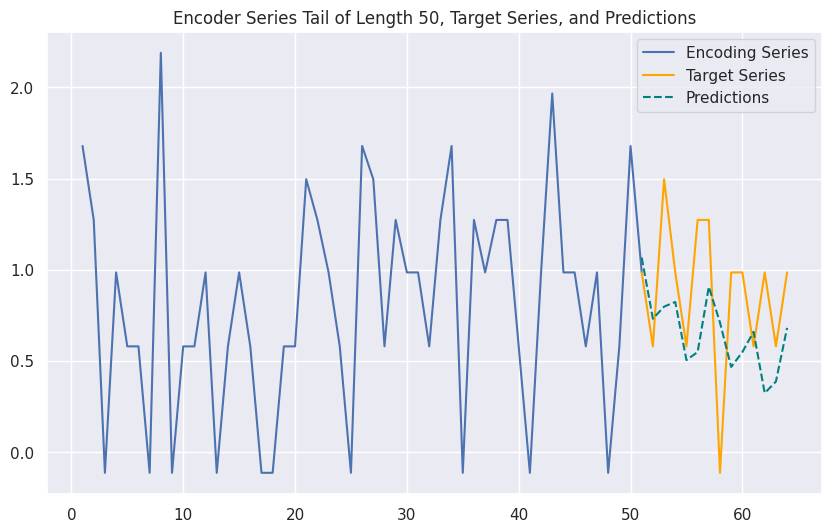

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 110005)

1/1 [==============================] - 0s 36ms/step


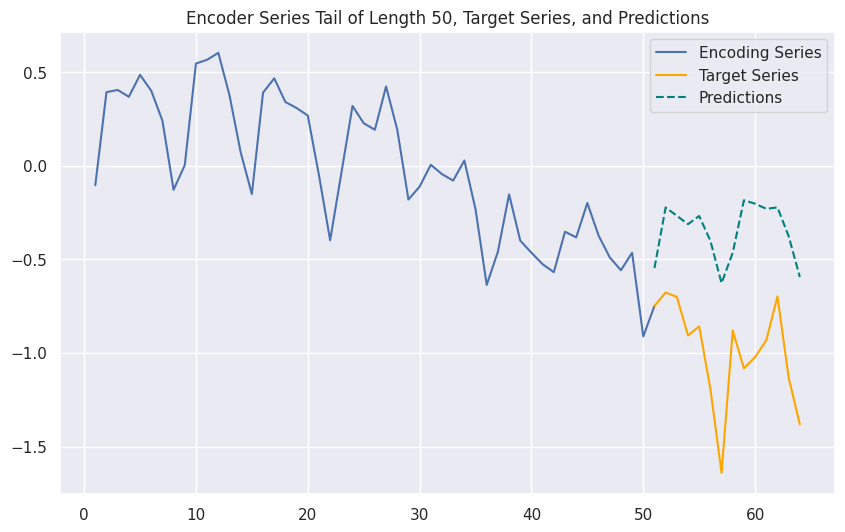

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 70000)

This last prediction example is interesting - the model clearly understands the recurring pattern in the series well, but struggles to properly capture the downward trend that's in place.